This notebook is intended as a companion to the paper "Robust inference of neutron-star parameters from thermonuclear burst observations" by D. K. Galloway et al., and includes simple examples of using methods as part of the `concord` repository to demonstrate the inference of neutron star properties & burst fuel composition from observations and comparison with simulated data. 

The sections below largely follow the discussion in the paper, and include examples of data analysis from 
1. 4U 0513+40
1. Kepler simulations
1. GS 1826-24
1. XMMU J181227.8-181234 (= XTE J1812-182)
1. IGR J17591-2342
1. IGR J00291+5934
1. _and possibly_ SAX J1810.8-2609

The analysis approaches are broken into cases depending on the extent of the available data; e.g. pairs (or trains) of bursts with well-constrained recurrence times, all the way down to no bursts at all. See below for these examples

The notebook has been tested with the following packages:
* `python` 3.8.5
* `matplotlib` 3.5.0
* `astropy` 5.0
* `ChainConsumer` 0.33.0
* `astroquery` 0.4.5
* `scipy` 1.7.3

See `README.md` for quickly creating a working environment and the end of this notebook for the modification history

In [1]:
import sys
print ('Python version {}'.format(sys.version))

Python version 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]


In [2]:
import concord as cd

from astropy.io import ascii
from astropy.table import Table
import astropy.units as u
import pandas as pd
import numpy as np

import astropy.constants as const
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support 
import astropy.uncertainty as unc

from chainconsumer import ChainConsumer
from numpy.random import normal, multivariate_normal
#from math import *
import math

%matplotlib inline

flux_unit = u.erg/u.cm**2/u.s
mdot_Edd = 8.8e4*u.g/u.cm**2/u.s

# Just checking

import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

import astropy
print('astropy version {}'.format(astropy.__version__))

matplotlib: 3.5.1
astropy version 5.0.4


In [3]:
# Some preliminaries

opz = cd.OPZ
R_Newt = 10*u.km
M_NS =  cd.M_NS
R_NS = cd.solve_radius(M_NS, R_Newt)
opz = cd.redshift(M_NS, R_NS)
g = cd.g(M_NS, R_NS)

print ('Calculations & simulations for:\n  M_NS = {}, R_Newt = {}, R_GR = {:.3f}\n  [ Check: g {:.3e} =? {:.3e} ]'.format(
    M_NS, R_Newt, R_NS, g.value, cd.g(M_NS, R_Newt, Newt=True)))


Calculations & simulations for:
  M_NS = 1.4 solMass, R_Newt = 10.0 km, R_GR = 11.218 km
  [ Check: g 1.858e+14 =? 1.858e+14 cm / s2 ]


## 2.1 Emission anisotropy

Here we illustrate the various anisotropy factors as a function of system inclination. A call to the `anisotropy` routine with `test=True` will generate this plot

/Users/duncan/projects/concord/concord/diskmodel.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Example anisotropy values for i=30: xi_b = 0.7187, xi_p = 0.4934


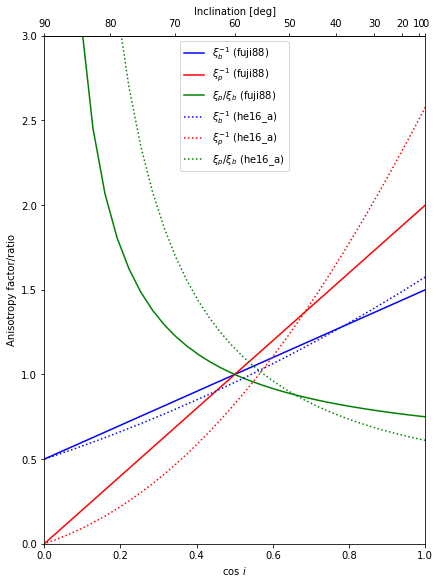

In [4]:
xi_b, xi_p = cd.anisotropy(30*u.degree,test=True)
print ('Example anisotropy values for i=30: xi_b = {:.4f}, xi_p = {:.4f}'.format(xi_b, xi_p))

# plt.savefig("anisotropy.pdf", bbox_inches='tight')

## 2.3 Burst energetics and fuel composition

Here we derive the expected ranges for the $\alpha$-value for conservative burning, for a $1.4\ M_\odot$ neutron star with $R=11.6$ km

In [5]:
qnuc_He = cd.Q_nuc(0.)
qnuc_solar = cd.Q_nuc(0.7)

qgrav = (const.c**2*(opz-1)/opz).to('MeV g-1')*const.m_p.to('g')

print ('Q_nuc for H-rich material (X=0.7) is {:.4f}; Q_grav is {:.1f}'.format(qnuc_solar*u.MeV, qgrav))

print ('Expected range of alpha-value (excluding anisotropy effects) is {:.1f}-{:.1f}'.format(
    qgrav/(qnuc_solar*u.MeV), qgrav/(qnuc_He*u.MeV)))

Q_nuc for H-rich material (X=0.7) is 5.2291 MeV; Q_grav is 192.7 MeV
Expected range of alpha-value (excluding anisotropy effects) is 36.9-147.7


Typically the average H-fraction at ignition $\overline{X}$ is reduced compared to the accreted value $X_0$ by the effects of steady hot-CNO burning prior to ignition. Here we use equations 14-16 in the paper, to illustrate the relationship between the two, for various cases of recurrence time and $Z_\mathrm{CNO}$

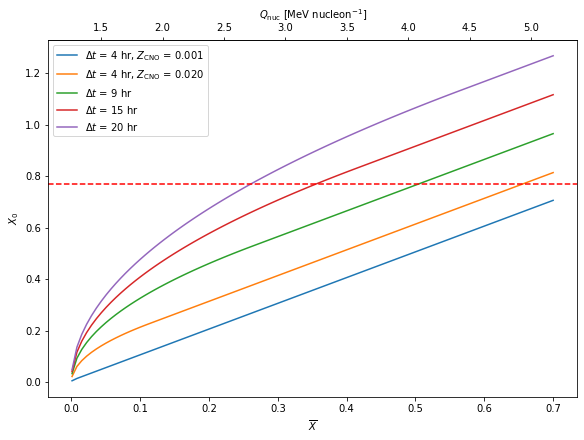

In [6]:
# Generate an array of Xbar values

nsamp = 100
Xbar_arr = np.linspace(0.001,0.7,nsamp)
Xbar_arr

x_0 = np.zeros(nsamp)
Z_CNO = 0.001 # CNO metallicity for the first line; we switch to "solar" after that
#dt1 = 4.*u.hr
dt_array = np.linspace(4.,20.,4)
dt_array = np.insert(dt_array,0,4.)

fig, ax = plt.subplots(constrained_layout=True)

# Loop over each of the recurrence time values, and plot the line
for j, dt1 in enumerate(dt_array):
    for i in range(nsamp):
        # print (i,Xbar.distribution[i],Z_CNO[i],dt1.distribution[i].to('hr'))
        x_0[i] = cd.X_0(Xbar_arr[i],Z_CNO,dt1*u.hr)

    if j <= 1:
        ax.plot(Xbar_arr, x_0, label='$\Delta t$ = {:.0f} hr, $Z_\mathrm{{CNO}}$ = {:.3f}'.format(
            dt1, Z_CNO))
    else:
        ax.plot(Xbar_arr, x_0, label='$\Delta t$ = {:.0f} hr'.format(dt1))

    
    Z_CNO = 0.02
ax.set_xlabel("$\overline{X}$")
ax.set_ylabel("$X_0$")
ax.axhline(0.77,linestyle='--',color='r')

def Xbar(qnuc):
    '''
    Inverse function to Q_nuc, to generate the secondary axis
    '''
    
    q = cd.Q_nuc(0.,quadratic=False, coeff=True)
                 
    return (qnuc-q[0])/q[1]

secax = ax.secondary_xaxis('top', functions=(cd.Q_nuc, Xbar))
secax.set_xlabel("$Q_\mathrm{nuc}$ [MeV nucleon$^{-1}$]")
ax.legend()

fig.set_size_inches(8,6)
# fig.savefig("xbar.pdf", bbox_inches='tight')

## 3. Peak luminosity of a burst

This section provides a simple introduction to the routines of the code and how incorporating the astrophysical uncertainties can affect the measurements. We adopt measurements of peak flux for a burst from 4U 0513+40 measured by _RXTE_, as part of the MINBAR sample ([Galloway et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..249...32G)); the distance measurement for the host cluster NGC 1851 from [Watkins et al. (2015)](http://adsabs.harvard.edu/abs/2015ApJ...812..149W); and the lower limit on the system inclination from [Fiocchi et al. (2011)](http://adsabs.harvard.edu/abs/2011MNRAS.414L..41F).

The warnings about `no bolometric correction applied` can be ignored, since we're dealing with (estimated) bolometric luminosities.

In [7]:
d = (10.32, 0.24, 0.20) # asymmetric errors from Watkins et al. 2015
imin, imax = 80, 90 # degrees assumed

# Retrieve the burst measurements from MINBAR, if available

id = 3443 # burst from 4U~0513-40 with RXTE/PCA on MJD 54043.68857 obsID 92403-01-15-04
try:
    import minbar as mb
    has_minbar = True
    
    b = mb.Bursts()
    F_pk, F_pk_err = b[id]['bpflux'], b[id]['e_bpflux']
    name, time, obsid = b[id]['name'], b[id]['time'], b[id]['obsid']
except:
    has_minbar = False
    F_pk, F_pk_err = 21.72, 0.6 # 1E-9 erg/cm^2/s bolometric
    name, time, obsid = '4U 0513-40', 54043.68857, '92403-01-15-04'
    
print ('''Burst #{}, observed from {} on MJD {:.5f} (obsid {});
  Peak (bolometric) flux is {:.2f} +/- {:.2f} E-9 erg/cm^2/s'''.format(
    id, name, time, obsid, F_pk, F_pk_err))

# Now calculate the various luminosities
# In the absence of units for the flux, MINBAR units are assumed; in this case 1e-9 erg/cm^2/s
l_iso = cd.luminosity( F_pk, dist=d[0], isotropic=True )

# For the MCMC version, we use 10000 samples (1000 is the default) to get smoother 
# distributions for final values
l_asym = cd.luminosity( (F_pk, F_pk_err), dist=d, burst=True, imin=imin, imax=imax, 
                        fulldist=True, nsamp=10000)
lc = l_asym['lum'].pdf_percentiles([50, 50 - cd.CONF / 2, 50 + cd.CONF / 2])

l_unit = 1e38*u.erg/u.s
print ('''\nIsotropic luminosity is {:.2f}e38 erg/s
  Taking into account anisotropy, ({:.2f}-{:.2f}+{:.2f})e38 erg/s'''.format(l_iso/l_unit, 
                                                                            lc[0]/l_unit, 
                                                (lc[0]-lc[1])/l_unit, (lc[2]-lc[0])/l_unit))

Burst #3443, observed from 4U 0513-40 on MJD 54043.68857 (obsid 92403-01-15-04);
  Peak (bolometric) flux is 21.72 +/- 0.60 E-9 erg/cm^2/s

Isotropic luminosity is 2.77e38 erg/s
  Taking into account anisotropy, (4.85-0.42+0.47)e38 erg/s


Now we plot all the derived parameters, to demonstrate their codependence. 

Note also the additional clause when plotting the distribution objects, to provide the unit support; see https://docs.astropy.org/en/stable/uncertainty

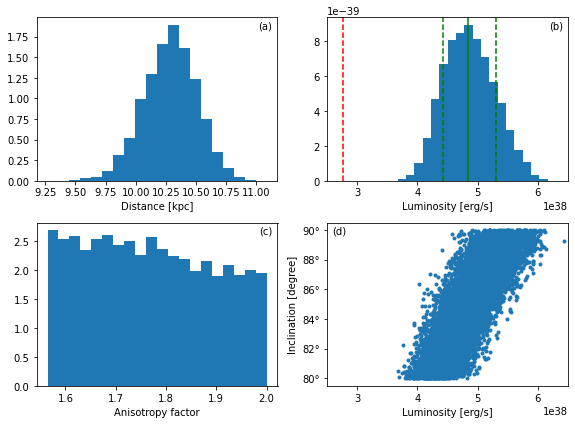

In [8]:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# https://www.kite.com/python/answers/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python

fig0, axs0 = plt.subplots(2, 2)
fig0.set_size_inches(8,6)

with quantity_support():
    axs0[0, 1].hist(l_asym['lum'].distribution,bins=20,density=True, 
         label='Luminosity (erg/s)')
    axs0[0, 1].axvline(l_iso,color='r',ls='--')
    axs0[0, 1].axvline(lc[1],color='g',ls='--')
    axs0[0, 1].axvline(lc[2],color='g',ls='--')
    axs0[0, 1].set_xlim((2.5e38,6.5e38))
    axs0[0, 1].set_xlabel('Luminosity [erg/s]')
    axs0[0, 1].axvline(lc[0],color='g')
    
    axs0[0, 1].text(0.95, 0.95, '(b)', horizontalalignment='center',
      verticalalignment='center', transform=axs0[0,1].transAxes)

    axs0[0,0].hist(l_asym['dist'].distribution, bins=20, density=True)
    axs0[0,0].set_xlabel('Distance [kpc]')
    
    axs0[0, 0].text(0.95, 0.95, '(a)', horizontalalignment='center',
      verticalalignment='center', transform=axs0[0,0].transAxes)

    axs0[1,1].plot(l_asym['lum'].distribution, l_asym['i'].distribution, '.')
    # axs0[1,1].set_xlim((2.5e38,6.5e38))
    axs0[1, 1].sharex(axs0[0, 1])
    axs0[1,1].set_xlabel('Luminosity [erg/s]')
    axs0[1,1].set_ylabel('Inclination [degree]')

    axs0[1, 1].text(0.05, 0.95, '(d)', horizontalalignment='center',
      verticalalignment='center', transform=axs0[1,1].transAxes)

    axs0[1,0].hist(l_asym['xi'].distribution, bins=20, density=True)
    axs0[1,0].set_xlabel('Anisotropy factor')

    axs0[1,0].text(0.95, 0.95, '(c)', horizontalalignment='center',
      verticalalignment='center', transform=axs0[1,0].transAxes)


fig0.tight_layout()
# fig0.savefig("fig0.pdf", bbox_inches='tight')

# 3.1 Code validation

As a preliminary test for the relations in the paper, we use the set of "xbar" Kepler runs as for [Goodwin et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...870...64G), which have a measured $\overline{X}$ (mean H-fraction at ignition).

These data are summarised in the `table1.mrt` file, supplied with the paper (and this repository)

<TableColumns names=('run','mdot','X','Z','n_burst','n_avg','delm','trec','e_trec','fluen','e_fluen','Xbar','e_Xbar','Xign')>

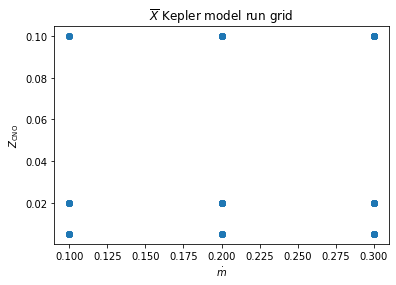

In [9]:
ft = ascii.read('table1.mrt')#, format='mrt')

plt.scatter(ft['mdot'],ft['Z'])
plt.xlabel('$\dot{m}$')
plt.ylabel('$Z_\mathrm{CNO}$')
plt.title('$\overline{X}$ Kepler model run grid')

ft.columns

First step is to test our Xbar calculation, to make sure equations 13 and 14 can replicate (approximately) what is measured from the Kepler models

Xbar RMS error: 0.0249
  for low Xbar: 0.0448
X_0 RMS error, excluding outliers: 0.0209


X,Z,mdot,n_burst,Xbar,e_Xbar,trec
,,,,,,h
float64,float64,float64,int64,float64,float64,float64
0.2,0.1,0.3,27,0.05115,0.02982,1.138
0.2,0.1,0.3,26,0.0516,0.03037,1.136
0.2,0.1,0.3,23,0.05287,0.03216,1.123
0.2,0.1,0.2,21,0.02996,0.03902,2.62
0.3,0.1,0.2,14,0.07959,0.06646,1.984
0.2,0.1,0.3,60,0.08376,0.06712,1.12
0.2,0.02,0.1,40,0.09593,0.07359,6.164
0.2,0.1,0.1,40,0.10195,0.09805,16.699


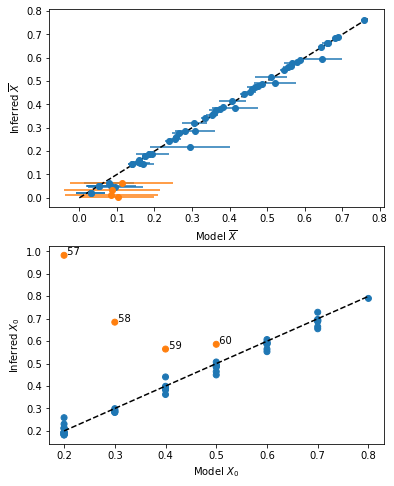

In [10]:
# Instead we can implement equations 13 and 14, neglecting the redshift factor, because
# the t_CNO (along with the recurrence time) are all measured in the NS frame

ft['t_CNO'] = 9.8*(ft['X']/0.7)/(ft['Z']/0.02) # hr

ft['f_burn'] = ft['trec']/ft['t_CNO']
ft['xbar_inf'] = ft['X']*(1-0.5*ft['f_burn'])
# exh = np.where(full_table['average recurrence time (s)']/3600. > full_table['t_CNO'])[0]
exh = np.where(ft['trec'] > ft['t_CNO'])[0]

# full_table['xbar_inf'][exh] = full_table['X'][exh]
# full_table.loc[exh]['xbar_inf'] = 0.5*full_table.loc[exh]['X']/full_table.loc[exh]['f_burn']

ft['xbar_inf'][exh] = 0.5*ft[exh]['X']/ft[exh]['f_burn']

# ... and our Xbar - X_0 function

ft['X_inf'] = [cd.X_0(ft['Xbar'][i], ft['Z'][i], 
                           ft['trec'][i]*ft['trec'].unit) 
                       for i in range(len(ft))]

# here identify the "bad" values of X_0_inf

ex = abs(ft['X']-ft['X_inf']) > 0.075

# ... and set up a colour array to plot them
# https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/

col = ['C1' if x else 'C0' for x in ex]

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axs = plt.subplots(2)
fig.set_size_inches(6,8)

# Want to show the horizontal error bars to illustrate the  burst-to-burst variations
# in the simulation results
# axs[0].scatter(ft['Xbar'],ft['xbar_inf'],c=col)
iex = np.where(~ex)[0]
axs[0].errorbar(ft['Xbar'][iex],ft['xbar_inf'][iex],xerr=ft['e_Xbar'][iex],fmt='o')
iex = np.where(ex)[0]
axs[0].errorbar(ft['Xbar'][iex],ft['xbar_inf'][iex],xerr=ft['e_Xbar'][iex],fmt='o')

axs[0].plot([0.0, 0.77], [0.0, 0.77], 'k--')
axs[0].set_xlabel('Model $\overline{X}$')
axs[0].set_ylabel('Inferred $\overline{X}$')
# plt.ylim(-0.4, 0.79)

# mark the problematic ones from the next plot

# ex = np.where((full_table['run no.'] >= 57) & (full_table['run no.'] <=60))[0]
# for i in ex:
#     # print (i, full_table.iloc[i]['run no.'], full_table.iloc[i]['xbar'], full_table.iloc[i]['xbar_inf'])
#     axs[0].annotate(' {:.0f}'.format(full_table.iloc[i]['run no.']), 
#         (full_table.iloc[i]['xbar'], full_table.iloc[i]['xbar_inf']))
    
# quantify the error here

xbar_rms = np.sqrt(np.mean((ft['Xbar']-ft['xbar_inf'])**2))
print ('Xbar RMS error: {:.4f}'.format(
    xbar_rms))
loX = np.where(ft['Xbar'] < 0.13)[0]
print ('  for low Xbar: {:.4f}'.format(
    np.sqrt(np.mean((ft['Xbar'][loX]-ft['xbar_inf'][loX])**2))))

# Second plot

axs[1].scatter(ft['X'], ft['X_inf'], c=col)

axs[1].plot([0.2, 0.8], [0.2, 0.8], 'k--')
axs[1].set_xlabel('Model $X_0$')
axs[1].set_ylabel('Inferred $X_0$')

# https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point

for i in np.where(ex)[0]:
    # print (i, full_table.iloc[i]['run no.'], full_table.iloc[i]['X'], full_table.iloc[i]['X_inf'])
    axs[1].annotate(' {}'.format(ft['run'][i]), 
        (ft['X'][i], ft['X_inf'][i]))
    
# quantify the error here

excl = np.where((ft['run'] < 57) | (ft['run'] > 60))[0]
X_0_rms = np.sqrt(np.mean((ft['X'][excl]-ft['X_inf'][excl])**2))
print ('X_0 RMS error, excluding outliers: {:.4f}'.format(
    X_0_rms))
# print ('for low Xbar: {:.4f}'.format(
#     np.sqrt(np.mean((full_table.loc[loX]['xbar']-full_table.loc[loX]['xbar_inf'])**2))))

# fig.savefig("validation.pdf", bbox_inches='tight')

ft[['X','Z','mdot','n_burst','Xbar','e_Xbar','trec']][loX]

The agreement between the $\overline{X}$ inferred from equations 13 and 14, and measured from the model outputs, is fairly good, similar for the $X_0$. The four most significant outliers are at the low-accretion rate (0.1 mdot_Edd) and high Z_CNO (0.1), but also have unusually large scatter in the recurrence times (and hence $\overline{X}$ values; highlighted in orange).

The issue is not just because they get to low values of $\overline{X}$, as other runs get to smaller values but have more consistent inferred values.

In [11]:
# full_table[full_table['runid'] >= 57]
# ft.sort_values('xbar')[:10]
ft.sort('Xbar')
ft[:10]

run,mdot,X,Z,n_burst,n_avg,delm,trec,e_trec,fluen,e_fluen,Xbar,e_Xbar,Xign,t_CNO,f_burn,xbar_inf,X_inf
,,,,,,1e+20 g,h,h,1e+38 erg,1e+38 erg,,,,,h,,
int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
63,0.2,0.2,0.1,22,20,19.768,2.616,0.066,24.75,1.02,0.02996,0.03902,0.01,0.5600000000000002,4.67142857142857,0.021406727828746187,0.21086907426489637
36,0.2,0.2,0.1,21,20,19.768,2.62,0.065,24.79,1.03,0.02996,0.03902,0.01,0.5600000000000002,4.678571428571427,0.021374045801526725,0.21103022757406173
15,0.3,0.2,0.1,27,26,13.082,1.138,0.059,17.89,2.13,0.05115,0.02982,0.00769,0.5600000000000002,2.0321428571428566,0.04920913884007032,0.1817259999135875
21,0.3,0.2,0.1,26,25,13.068,1.136,0.065,18.16,3.31,0.0516,0.03037,0.008,0.5600000000000002,2.0285714285714276,0.04929577464788735,0.18236317030096688
28,0.3,0.2,0.1,23,22,12.843,1.123,0.058,18.16,3.51,0.05287,0.03216,0.00909,0.5600000000000002,2.005357142857142,0.04986642920747998,0.18353447355804262
37,0.2,0.3,0.1,14,12,14.498,1.984,0.033,22.51,3.81,0.07959,0.06646,0.025,0.8400000000000001,2.3619047619047615,0.06350806451612905,0.2993113621317965
42,0.3,0.2,0.1,60,4,10.354,1.12,0.066,20.47,6.13,0.08376,0.06712,0.05,0.5600000000000002,1.9999999999999996,0.05000000000000002,0.23070152364110139
58,0.1,0.3,0.1,60,4,28.842,9.706,0.193,44.38,3.75,0.08516,0.12403,0.075,0.8400000000000001,11.554761904761904,0.012981660828353597,0.6847957983033186


Now we do a more extensive and realistic simulation, choosing randomly-distributed inclinations, looping over the available models, and generating some random samples for each one

We keep redshift and radius fixed, although for full realism you might also draw from distributions on both these parameters also.

In [12]:
n_rows = len(ft)
n_per_run = 10

# Arbitrary (but realistic) distance and bolometric correction

d = 6*u.kpc
bol_corr = 1.4

# Generate an array of inclinations

# i = 50*u.deg
i = cd.iso_dist(nsamp=n_per_run*n_rows)

# Define the result array
# columns are run ID, X_sim, inclination, X_meas, X_meas_lo, X_meas_hi]

res_arr = np.zeros((6,n_per_run*n_rows))
res_arr[2,:] = i.distribution
# res_arr

ft.sort('run')
for i in range(n_rows):
    print ('Simulating run id {}...'.format(ft['run'][i]))
    
    # Now transform the data into observations, given a distance, redshift and inclination
    # Recurrence time

    tdel = (ft['trec'][i], ft['e_trec'][i])*u.hr
    tdel *= opz

    mdot_Edd = 8.8e4*1.7/(1+ft['X'][i])*u.g/u.cm**2/u.s
    for j in range(n_per_run):
        
        res_arr[0,i*n_per_run+j] = ft['run'][i]
        res_arr[1,i*n_per_run+j] = ft['X'][i]
        
        # Fluence transforms the same way as flux, but we have to add (and then remove) 
        # seconds as a unit to get the right dimensions

        e_b = cd.lum_to_flux( (ft["fluen"][i]*1e38, 
                               ft['e_fluen'][i]*1e38)*u.erg/u.s, dist=d, burst=True, dip=False,
                        isotropic=False, inclination=res_arr[2,i*n_per_run+j], fulldist=True)
    
        e_b = e_b["flux"]*u.s

        # Persistent flux
        # Need to work out what mdot is in real physical units to use this

        mdot = (ft['mdot'][i]*mdot_Edd*4*math.pi*R_NS**2).to('g s-1')

        fper = cd.fper(mdot, (d, res_arr[2,i*n_per_run+j], opz, 0.0), c_bol=bol_corr)

        xbar = cd.hfrac(tdel, fper=fper, fluen=e_b, c_bol=bol_corr,
                  isotropic=False, inclination=None, fulldist=True)

        # save results; now X_0 might have -1 values, so trap those here
        
        gz = np.where(xbar['X_0'].distribution >= 0.)[0]
        if len(gz) > 2:
        
            xpc = np.percentile(xbar['X_0'].distribution[gz],(50,16,84))
            res_arr[3,i*n_per_run+j] = xpc[0]
            res_arr[4,i*n_per_run+j] = xpc[0]-xpc[1]
            res_arr[5,i*n_per_run+j] = xpc[2]-xpc[0]

Simulating run id 1...


Simulating run id 2...


Simulating run id 3...


Simulating run id 4...


Simulating run id 5...


Simulating run id 6...


Simulating run id 7...


Simulating run id 8...


Simulating run id 9...


Simulating run id 10...


Simulating run id 11...


Simulating run id 12...


Simulating run id 13...


Simulating run id 14...


Simulating run id 15...


Simulating run id 16...


Simulating run id 17...


Simulating run id 18...


Simulating run id 19...


Simulating run id 20...


Simulating run id 21...


Simulating run id 22...


Simulating run id 23...


Simulating run id 24...


Simulating run id 25...


Simulating run id 26...


Simulating run id 27...


Simulating run id 28...


Simulating run id 29...


Simulating run id 31...


Simulating run id 32...


Simulating run id 33...


Simulating run id 34...


Simulating run id 35...


Simulating run id 36...


Simulating run id 37...


Simulating run id 38...


Simulating run id 39...


Simulating run id 40...


Simulating run id 41...


Simulating run id 42...


Simulating run id 43...


Simulating run id 44...


Simulating run id 45...


Simulating run id 46...


Simulating run id 47...


Simulating run id 48...


Simulating run id 49...


Simulating run id 50...


Simulating run id 51...


Simulating run id 52...


Simulating run id 53...


Simulating run id 54...


Simulating run id 55...


Simulating run id 56...


Simulating run id 57...


Simulating run id 58...


Simulating run id 59...


Simulating run id 60...


Simulating run id 63...


<TableColumns names=('run','mdot','X','Z','n_burst','n_avg','delm','trec','e_trec','fluen','e_fluen','Xbar','e_Xbar','Xign','t_CNO','f_burn','xbar_inf','X_inf')>
X_0 RMS error: 0.0980
X_0 RMS error low Z: 0.0523


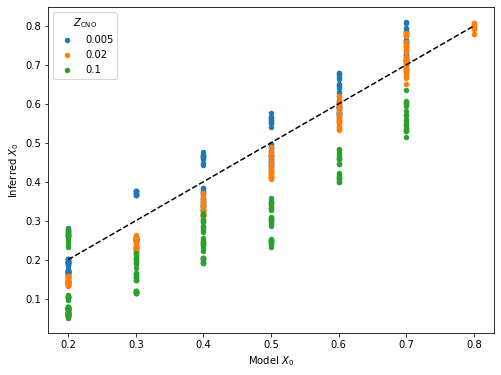

In [13]:
# If we convert to a DataFrame, we can do some more useful stuff
# But we first need to also convert the simulation table to a DataFrame

print(ft.columns)
ft_df = ft.to_pandas()
# ft_df

# np.shape(res_arr)
ra = pd.DataFrame(res_arr.T, columns=['run', 'X', 'inclination', 'X_meas', 'X_meas_lo', 'X_meas_hi'])
ra = pd.merge(ra, ft_df, on='run')

# Now plot the results

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
colors = {0.005: 'C0', 0.02: 'C1', 0.1: 'C2'}
res_arr[:,:30]

grouped = ra.groupby('Z')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='X_x', y='X_meas', label=key, color=colors[key])
ax.legend(title='$Z_\mathrm{CNO}$')
ax.plot([0.2, 0.8], [0.2, 0.8], 'k--')
ax.set_xlabel('Model $X_0$')
ax.set_ylabel('Inferred $X_0$')

X_0_rms = np.sqrt(np.mean((res_arr[1,:]-res_arr[3,:])**2))
print ('X_0 RMS error: {:.4f}'.format(
    X_0_rms))

# Now the Z_CNO range is pretty huge (factor of 20). Try to restrict to the 
# 0.005-0.02 values here

loZ = ra['Z'] < 0.1
# ra[loZ]

X_0_rms_loZ = np.sqrt(np.mean((ra['X_x'][loZ]-ra['X_meas'][loZ])**2))
print ('X_0 RMS error low Z: {:.4f}'.format(
    X_0_rms_loZ))# Now plot the results

# plt.savefig("X0.pdf", bbox_inches='tight')

Another way to demonstrate the achievable precision is the fractional error distributions as a function of Z_CNO mismatch, split for the "low Z" dat ($Z_{\rm CNO}=0.005, 0.02$) and the "high Z" ($Z_{\rm CNO}=0.1$). 

Since we assume $Z_{\rm CNO}$ is 0.02 across the board, the mismatch with the "high Z" group is greatest (and the distribution of fractional errors are also higher on average)

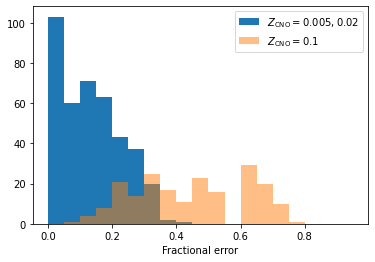

In [14]:
ra['fracerr'] = abs(ra['X_x']-ra['X_meas'])/ra['X_x']
plt.hist(ra['fracerr'][loZ],bins=np.arange(20)/20.,label='$Z_\mathrm{CNO}=0.005, 0.02$')
plt.hist(ra['fracerr'][~loZ],bins=np.arange(20)/20.,alpha=0.5,label='$Z_\mathrm{CNO}=0.1$')

plt.xlabel('Fractional error')
plt.legend()

## 3.2 Two or more regular, consistent bursts

For the three sources in the reference burst sample ([Galloway et al. 2017](http://adsabs.harvard.edu/abs/2017PASA...34...19G)), we have moderately good constraints on the composition; so test how well the current analyses reproduce those values here

First read in the data from the reference burst sample; this is done as part of `concord`, where we define an arbitrary `ObservedBurst` object to trigger reading in the table

In [15]:
# It doesn't matter which burst you choose here; this is just
# to trigger concord to read the reference burst table

obs = cd.ObservedBurst.ref('GS 1826-24', 3.5)

i = 0 # select the first epoch burst from 1826
obs.table[i:i+3]

Epoch,$N_{\rm burst}$ ($N_{\rm av}$),burst IDs$^a$,$\Delta t$ (hr),$F_{\rm per}^b$ ($10^{-9}\ \epcs$),$c_{\rm bol}$,$\dot{m}$ ($\dot{m}_{\rm Edd}$),$E_b$ ($10^{-6}\ \epc$),$F_{\rm pk}$ ($10^{-9}\ \epcs$),$\alpha$,file
str11,str5,str6,str28,str15,str16,str10,str15,str17,str13,str26
1998 Jun,6(1),7,$5.14\pm0.07$,$1.167\pm0.006$,$1.806\pm0.009$,0.0513,$1.102\pm0.011$,$30.9\pm1.0$,$34.2\pm0.5$,gs1826-24_5.14h.dat
2000 Sep,11(7),14--20,$4.177\pm0.010$,$1.593\pm0.017$,$1.787\pm0.003$,0.0692,$1.126\pm0.016$,$29.1\pm0.5$,$38.6\pm0.3$,gs1826-24_4.177h.dat
2007 Mar,10(7),58--65,$3.530\pm0.004$,$1.87\pm0.02$,$1.751\pm0.003$,0.0796,$1.18\pm0.04$,$28.4\pm0.4$,$35.3\pm1.0$,gs1826-24_3.530h.dat


For GS 1826-24, [Meisel et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...860..147M) suggested an inclination of 65 or 80 deg; [Johnston et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.4576J) found $i = 69^{+2}_{-3}$ degrees. Lack of dipping would suggest its $\lesssim75$

Below we calculate the $\alpha$-value via `concord` for comparison with the tabled value, which was calculated in a slightly different way originally.

concord alpha-value for epoch 1998 Jun is 35.39_-0.65^0.66


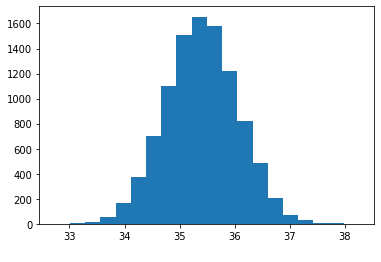

In [16]:
# print (obs.table[i])

tdel = cd.decode_LaTeX(obs.table[i][3])
fper, e_fper = cd.decode_LaTeX(obs.table[i][4])
fluen, fluene  = cd.decode_LaTeX(obs.table[i][7])
bc, bce = cd.decode_LaTeX(obs.table[i][5])

alpha = cd.alpha(tdel, (fluen, fluene), (fper, e_fper), c_bol=(bc, bce), 
                    fulldist=True,nsamp=10000)

with quantity_support():
    plt.hist(alpha['alpha'].distribution,bins=20)
    
result = cd.intvl_to_errors( np.percentile(alpha['alpha'].distribution, [50, 50-cd.CONF/2., 50+cd.CONF/2.]))

print ("concord alpha-value for epoch {} is {:.2f}_{:.2f}^{:.2f}".format(
    obs.table[i][0],result[0],-result[1],result[2]))

Below we can generate the $X_0$ values for each epoch, and plot them as a simple histogram (`histogram = True`), or demonstrating the dependence also on the inclination (`histogram = False`; latter is the plot in the paper, Figure 5)

(5.14, 0.07) 1.102 1.167 (1.806, 0.009) [0.57870949 0.63936233 0.695029  ]
(4.177, 0.01) 1.126 1.593 (1.787, 0.003) [0.50881017 0.55663916 0.60920735]
(3.53, 0.004) 1.18 1.87 (1.751, 0.003) [0.5366371  0.59491658 0.65377027]


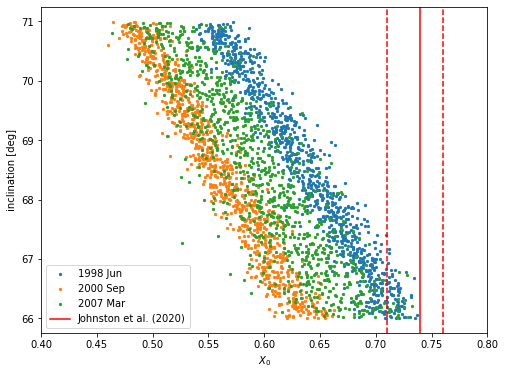

In [17]:
# Loop over the three epochs and determine the X_0 distribution for each one, comparing with
# Johnston et al. 20

histogram = False # can switch between histogram and scatter plot

plt.rcParams["figure.figsize"] = (8,6)

Z_CNO=0.02
for i in range(3):
    tdel = cd.decode_LaTeX(obs.table[i][3])
    fper, e_fper = cd.decode_LaTeX(obs.table[i][4])
    fluen, fluene  = cd.decode_LaTeX(obs.table[i][7])
    bc, bce = cd.decode_LaTeX(obs.table[i][5])
# Could calculate alpha via the other parameters, should really incorporate this into hfrac
# alpha = tex2val(obs.table[i][9])
# alpha =  np.random.normal(0., 1., size=nsamp) * alpha[1] + alpha[0]

# Here's the (new) built-in calculation in concord, for comparison

    # plt.hist(alpha.distribution,alpha=0.5,label=obs.table[i][0],bins=np.arange(30)/2.+30.)
    xbar = cd.hfrac(tdel*u.hr, fluen=(fluen, fluene), fper=(fper, e_fper), c_bol=(bc, bce), 
                    imin=66, imax=71, zcno=Z_CNO,
                    fulldist=True)#, imin=65, imax=80)

    if histogram:
        plt.hist(xbar['X_0'].distribution,alpha=0.5,label=obs.table[i][0],bins=np.arange(60)/60.,density=True)
    else:
        plt.scatter(xbar['X_0'].distribution,xbar['i'].distribution,label=obs.table[i][0],s=5)
    
    print (tdel, fluen, fper, (bc, bce), np.percentile(xbar['X_0'].distribution, (50-cd.CONF/2, 50, 50+cd.CONF/2)))

plt.xlabel('$X_0$')
plt.axvline(0.74,color='r',label='Johnston et al. (2020)') # central value from johnston20
plt.axvline(0.74-0.03,color='r',linestyle='--')
plt.axvline(0.74+0.02,color='r',linestyle='--')
plt.xlim(0.4,0.8)
if histogram:
    plt.ylim(0,11)
else:
    plt.ylabel('inclination [deg]')
plt.legend()

plt.savefig("fig1826.pdf", bbox_inches='tight')

The plot suggests that the code underestimates the fuel fraction by a few tens of percent, compared to the more detailed comparison to Kepler models. However, that comparison also finds $Z_{\rm CNO}\approx0.01$, compared to the 0.02 that we assume. Unfortunately reducing the CNO mass fraction gives us also reduced $X$, so there remains a discrepancy between our results and those of [Johnston et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.4576J).

$5.14\pm0.07$ $1.167\pm0.006$ $1.806\pm0.009$ $1.102\pm0.011$
(5.14, 0.07) 1.102 1.167 (1.806, 0.009) [0.44037454 0.49717675 0.55853254]
(5.14, 0.07) 1.102 1.167 (1.806, 0.009) [0.57886118 0.63536361 0.69327553]
(5.14, 0.07) 1.102 1.167 (1.806, 0.009) [0.65238552 0.71170122 0.7665732 ]


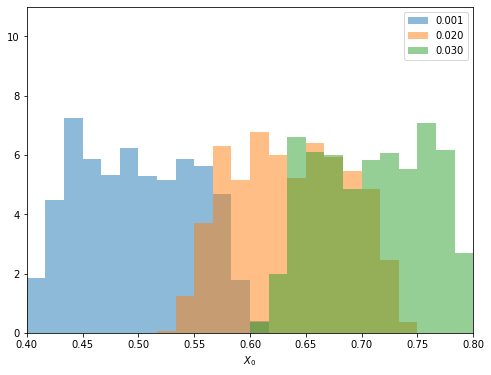

In [18]:
# For one of the epochs, experiment with the variation in Z

i=0
print (obs.table[i][3], obs.table[i][4], obs.table[i][5], obs.table[i][7])

for Z_CNO in (0.001, 0.02, 0.03):
    tdel = cd.decode_LaTeX(obs.table[i][3])
    fper, e_fper = cd.decode_LaTeX(obs.table[i][4])
    fluen, fluene  = cd.decode_LaTeX(obs.table[i][7])
    bc, bce = cd.decode_LaTeX(obs.table[i][5])
# Could calculate alpha via the other parameters, should really incorporate this into hfrac
# alpha = tex2val(obs.table[i][9])
# alpha =  np.random.normal(0., 1., size=nsamp) * alpha[1] + alpha[0]

# Here's the (new) built-in calculation in concord, for comparison

    # plt.hist(alpha.distribution,alpha=0.5,label=obs.table[i][0],bins=np.arange(30)/2.+30.)
    xbar = cd.hfrac(tdel*u.hr, fluen=(fluen, fluene), fper=(fper, e_fper), c_bol=(bc, bce), 
                    imin=66, imax=71, zcno=Z_CNO,
                    fulldist=True)#,debug=True)#, imin=65, imax=80)
    plt.hist(xbar['X_0'].distribution,alpha=0.5,bins=np.arange(60)/60.,density=True, label='{:.3f}'.format(Z_CNO))

    print (tdel, fluen, fper, (bc, bce), np.percentile(xbar['X_0'].distribution, (50-cd.CONF/2, 50, 50+cd.CONF/2)))

plt.xlabel('$X_0$')
plt.xlim(0.4,0.8)
plt.ylim(0,11)
plt.legend()

## 3.3 One (or more) bursts, no recurrence times

Here we analyse the bursts from XMMU J181227.8-181234 observed by _RXTE_, as also analysed by [Goodwin et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.486.4149G). A total of 6 bursts were observed over a total exposure time of 0.3446 d, with low duty cycle and hence many gaps in between. 

So we compute a distribution of mean recurrence times consistent with the measurements, and propagate this distribution through to the rest of the calculation

Assumed M_NS = 1.4 solMass, R_NS = 11.2000 km, 1+z = 1.2590, Z_CNO = 0.02
Synthetic distribution of tdel has 1.378_-0.514^0.487 h


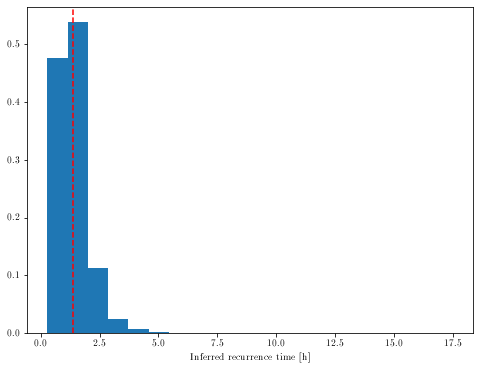

In [25]:
# Observations

exp = (0.3446*u.d).to('hr') # total exposure
nburst = 6 # total number of bursts observed (excluding SWT bursts)

fluen, fluene = 0.0241, 0.0073 # 1e-6 erg/cm^2
# fluen *= 2. # for testing
# fluene *=2.
# tdel, tdel_err = 1.38*u.hr, 0.56*u.hr
pflux, pfluxe = 1.19, 0.16 # 1e-9 erg/cm^2/s
bc = 2.522
f_unit = 1e-9*u.erg/u.cm**2

# Assumptions here

opz_def = cd.redshift(1.4*const.M_sun,11.2*u.km)

xmax = 0.77
zcno_def = 0.02
# zcno_def = 0.05 # acceptance fraction up to 13%

# Because the ultimate acceptance fraction is so small, you need to start with 
# many many samples to end up with anything to plot at the end

# nbin=1000000 # for paper plot
nbin=2000 # for testing

# some tests here

# opz_def*=1.1

z_def = opz_def-1.
print ("Assumed M_NS = {}, R_NS = {:.4f}, 1+z = {:.4f}, Z_CNO = {}".format(
#    M_NS,R_NS,1.+z_def,zcno_def))
    1.4*u.M_sun,11.2*u.km,1.+z_def,zcno_def))

# Estimate tdel and error based on Poisson stats
    
tdel_arr = cd.tdel_dist(nburst, exp, nsamp=nbin)
tdel = exp/nburst

# lim = np.percentile(y,(16,50,84))
lim = np.percentile(tdel_arr.distribution,(16,50,84))
# print (lim[1],lim[0],lim[2])
# print ('Synthetic distribution of tdel has {:.3f}_{:.3f}^{:.3f}'.format(
#     tdel.value,(exp/lim[2]-tdel).value,exp/lim[0]-tdel))
print ('Synthetic distribution of tdel has {:.3f}_{:.3f}^{:.3f}'.format(
    tdel.value,(lim[0]-tdel).value,lim[2]-tdel))

with quantity_support():
    plt.hist(tdel_arr.distribution,bins=20,density=True)
    plt.xlabel('Inferred recurrence time [h]')
    plt.axvline(tdel,linestyle='--',color='r')

alpha = 573.11 (68% range 351.33-1001.84)


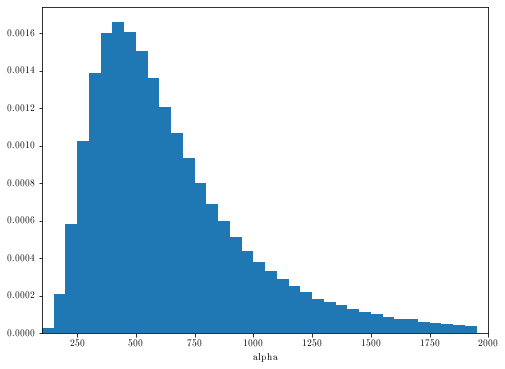

In [26]:
# Calculate alpha and plot the histogram, using the concord routine

# alpha = pflux*f_unit/u.s*bc*tdel.to('s')/(fluen*f_unit)
alpha = cd.alpha(tdel_arr,(fluen,fluene),(pflux,pfluxe),bc, fulldist=True)
alpha['alpha'].distribution

# These should be the same
# print(cd.len_dist(tdel_arr), cd.len_dist(alpha['alpha']))
assert cd.len_dist(tdel_arr) == cd.len_dist(alpha['alpha'])
with quantity_support():
    plt.hist(alpha['alpha'].distribution,bins=np.arange(0,2000,50),density=True)
plt.xlabel('alpha')
plt.xlim(100,2000)
# print (len(alpha))
# print (np.isscalar(alpha[3]))

# Also show the statistics

ap = np.percentile(alpha['alpha'].distribution,(16,50,84))
print ("alpha = {:.2f} (68% range {:.2f}-{:.2f})".format(ap[1],ap[0],ap[2]))

# print (len(alpha))

Calculating Xbar for 1000000 samples, this may take some time...
22075 1000000
Accepting 2.2075% of samples
For assumed 1+z = 1.2590, Z_CNO = 0.020, X_0 = 0.0430_0.0171^0.0965 (< 0.1494 @ 95%)
i = 51.0_28.2^67.8 deg


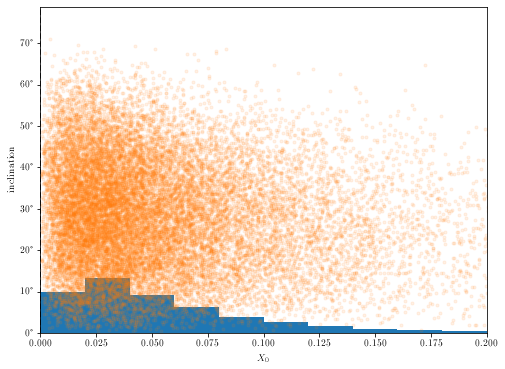

In [27]:
# Now calculate the H-fraction at ignition, and the corresponding fuel composition
# and sytsem inclination. Make sure to include fulldist=True to get the distributions

if (cd.len_dist(tdel_arr) > 2000):
    print ('Calculating Xbar for {} samples, this may take some time...'.format(cd.len_dist(tdel_arr)))
    
# Initial version of this calculation just used the fixed value of Z_CNO; but here
# we follow the earlier analysis by having a randomly distributed set of values

Z_CNO = np.random.random(nbin)*0.02

xbar = cd.hfrac(tdel_arr,alpha['alpha'],1+z_def,
                # zcno=zcno_def,
                zcno=Z_CNO,
                isotropic=False,fulldist=True)#,debug=True)

# Now plot the results

plt.hist(xbar['X_0'].distribution,bins=np.arange(0.,0.3,0.02), density=True)
plt.xlim(-0.1,0.8)
# plt.ylim(0,200)
plt.xlabel('inferred X_0')
plt.axvline(x=xmax,linestyle='--',color='k')
plt.axvline(x=0,linestyle='--',color='k')

good=np.where(np.logical_and(xbar['X_0'].distribution <= xmax,xbar['X_0'].distribution > 0))[0]
print (len(good), cd.len_dist(alpha['alpha']))

# Stats on the accepted samples

print ("Accepting {}% of samples".format(
    100.*len(good)/cd.len_dist(alpha['alpha'])))

# Display results
xp = np.percentile(xbar['X_0'].distribution[good],(50,16,84,95))
print ("For assumed 1+z = {:.4f}, Z_CNO = {:.3f}, X_0 = {:.4f}_{:.4f}^{:.4f} (< {:.4f} @ 95%)".format(
    1+z_def,zcno_def,xp[0], xp[1], xp[2], xp[3]))
ip = np.percentile(xbar['i'].distribution,(50,16,84))
print ("i = {:.1f}_{:.1f}^{:.1f}".format( ip[0].value, ip[1].value, ip[2]))

with quantity_support():
    # "bad" values are returned as -1, so no need to highlight the "good"
    plt.plot(xbar['X_0'].distribution,xbar['i'].distribution,'.', alpha=0.1)
    plt.xlim(0,0.2)
    plt.xlabel('$X_0$')
    plt.ylabel('inclination')
    # plt.plot(_x_0.distribution[good],i.distribution[good],'.')

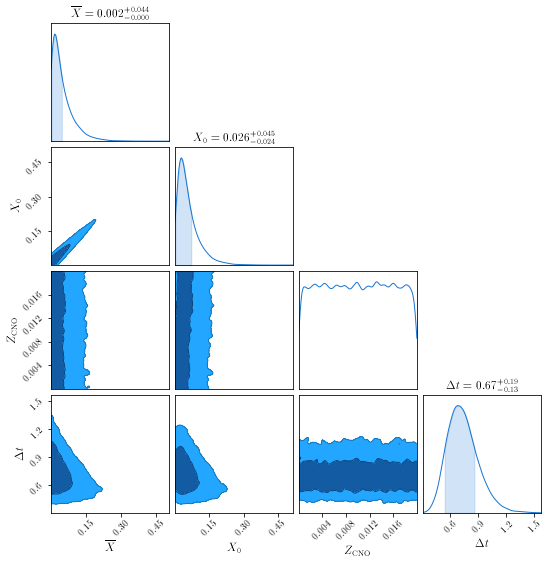

In [28]:
# and display, copying the approach from the previous source

data = np.vstack((xbar['xbar'].distribution[good], 
                  xbar['X_0'].distribution[good], 
                  Z_CNO[good], 
                  tdel_arr.distribution[good].value)).T
labels = ["$\overline{X}$", "$X_0$", "$Z_\mathrm{CNO}$", "$\Delta t$"]
# labels = ['X', '$X_0$', '$Z_\mathrm{CNO}$', '$Delta t$']

# not sure if this is necessary
matplotlib.rcParams['axes.unicode_minus'] = False

# If you pass in parameter labels and only one chain, you can also get parameter bounds
# kde=True will set smoothing on the chains, which you might not want
c = ChainConsumer().add_chain(data, parameters=labels, kde=False)

fig = c.plotter.plot(figsize=(8,8)
# uncomment the following line to save the plot
                                # ,filename='xmmuj181227.8-181234.pdf'
                                )

In [29]:
# Here we write out all the results
# This doesn't work yet...

print (cd.len_dist(tdel_arr),cd.len_dist(alpha),
       # cd.len_dist(_x_0),cd.len_dist(i),cd.len_dist(xbar)
       cd.len_dist(xbar['X_0']), cd.len_dist(xbar['i']), cd.len_dist(xbar['xbar']))
# xi_p, xi_b = cd.diskmodel.anisotropy(i)
xi_p, xi_b = cd.diskmodel.anisotropy(xbar['i'])

# d = {'fluen': fluen, 'pflux': pflux, 'tdel': tdel_arr, 'alpha': alpha,
d = {'tdel': tdel_arr.distribution, 'alpha': alpha['alpha'].distribution,
     # 'xbar': xbar, 'x_0': _x_0, 'theta': i, 
     'xbar': xbar['xbar'].distribution, 'x_0': xbar['X_0'].distribution, 'theta': xbar['i'].distribution,
     'xi_p': xi_p.distribution, 'xi_b': xi_b.distribution}

results = pd.DataFrame(data = d)
# plt.hist(results['alpha'],bins=100)
# results.to_csv('1812-182_sim_results.csv')

1000000 1 1000000 1000000 1000000


## 3.4 One burst – estimating the distance and burst rate

Here wefollow through the analysis of the (single) burst observed with _INTEGRAL_/JEM-X from IGR J17591-2342, with parameters extracted from Table 3 of [Kuiper et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...641A..37K)

In [30]:
src = 'IGR J17591-2342'
t0 = 58380.96358 # MJD
instr = 'IJ1'

F_pk, F_pk_err = 76., 14. # 1e-9 erg/cm^2/s
F_pers, F_pers_err = 1.2, 0.2 # 1e-9 erg/cm^2/s
E_b, E_b_err = 1.1, 0.1 # 1e-6 erg/cm^2

Distance limits including inclination constraint 7.70 kpc_-0.64 kpc^+0.84 kpc kpc (100000 samples);
  with burst anisotropy factor averaging xi_b = 0.70


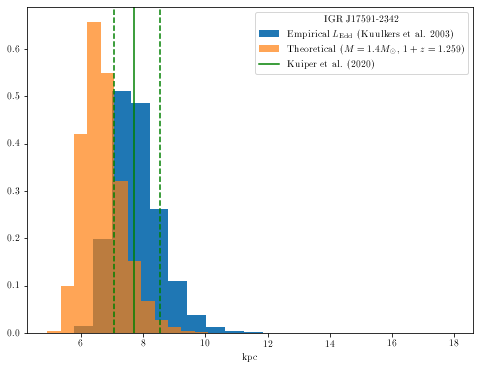

In [31]:
# There is a rough limit of 28-30 degrees for the inclination
# We can use that to constrain the various system parameters we've derived
# Use 100000 samples to make the figure for publication, with slightly smoother
# distributions
# Below we also illustrate two different ways to provide the units on the flux

dist_theo = cd.dist((F_pk, F_pk_err)*flux_unit*1e-9, empirical=False, fulldist=True, 
                    imin=24, imax=30, nsamp=100000)

dist2 = cd.dist((F_pk, F_pk_err), empirical=True, fulldist=True, 
                imin=24, imax=30, nsamp=100000)

fig2 = plt.figure()
fig2.set_size_inches(8,6)

with quantity_support():
    plt.hist(dist2['dist'].distribution,density=True,bins=20,label="Empirical $L_\mathrm{Edd}$ (Kuulkers et al. 2003)")

    plt.hist(dist_theo['dist'].distribution,density=True,bins=20,alpha=0.7,
            label='Theoretical ($M=1.4 M_\odot$, $1+z=1.259$)')
    
dper = np.percentile(dist2['dist'].distribution,(50,16,84))
plt.axvline(dper[0],color='g', label='Kuiper et al. (2020)')
plt.axvline(dper[1],color='g',ls='--')
plt.axvline(dper[2],color='g',ls='--')
# xiper = np.percentile(dist2['xi_b'][g],(50,16,84))

# These values for the paper

print ('''Distance limits including inclination constraint {:.2f}_{:.2f}^{:+.2f} kpc ({} samples);
  with burst anisotropy factor averaging xi_b = {:.2f}'''.format(
    dper[0], dper[1]-dper[0], dper[2]-dper[0], len(dist2['dist'].distribution),
    np.mean(dist2['xi_b'].distribution)))

plt.legend(title=src)

# fig2.savefig("fig2.pdf", bbox_inches='tight')

In [32]:
# Estimate the accretion rate

m2 = cd.mdot((F_pers,F_pers_err),dist2['dist'],inclination=dist2['i'],fulldist=True)#,nsamp=2000)

mdot = np.percentile(m2['mdot'].distribution,(50,16,84))
print ('''Accretion rate implied from persistent flux, with xi_p = {:.2f} (average) is {:.0f}_{:.0f}^{:+.0f} 
  or {:.3f}_{:.3f}^{:+.3f} in units of the Eddington accretion rate'''.format(
    np.mean(m2['xi_p'].distribution),
    mdot[0].value,(mdot[1]-mdot[0]).value,mdot[2]-mdot[0], #m2['mdot'].unit,
    (mdot[0]/mdot_Edd).value,((mdot[1]-mdot[0])/mdot_Edd).value,(mdot[2]-mdot[0])/mdot_Edd))

# len(m2['mdot'].distribution)

Accretion rate implied from persistent flux, with xi_p = 0.47 (average) is 1932_-428^+566 g / (cm2 s) 
  or 0.015_-0.003^+0.005 in units of the Eddington accretion rate


This calculation determines the ignition column; in the absence of a value for $\overline{X}$, a random distribution of values is used. A uniform distribution of $\overline{X}$ is perhaps not realistic, but it's substantially more work to do better. Also, large values of $\overline{X}$ are suppressed by the limit on $X_0$, down the track

In [33]:
# The size of the distribution has to be consistent with the distance array
nsamp = cd.len_dist(dist2['dist'])
# print (nsamp)

Xbar = unc.uniform(lower=0.0*u.dimensionless_unscaled, upper=0.7*u.dimensionless_unscaled,
                  n_samples=nsamp)

# Calculate the ignition column

y2 = cd.yign((E_b, E_b_err), dist2['dist'], inclination=dist2['i'], 
             Xbar=Xbar, fulldist=True)

# Now the recurrence time

dt1 = y2['yign']/m2['mdot']*cd.OPZ
# print (type(dt1))

In [34]:
# The combination of Xbar and recurrence time constrain X_0 and Z_CNO. 
# For each pair, we calculate the values here

Z_CNO = np.random.random(nsamp)*0.02

x_0 = np.zeros(nsamp)
for i in range(nsamp):
    # print (i,Xbar.distribution[i],Z_CNO[i],dt1.distribution[i].to('hr'))
    x_0[i] = cd.X_0(Xbar.distribution[i],Z_CNO[i],dt1.distribution[i].to('hr'))

# We restrict to physical values i.e. x_0 < 0.75

g = np.where(x_0 < 0.75)[0]

print ('Acceptance fraction {:.2f}% of {} samples'.format(100*len(g)/len(x_0), len(x_0)))

Acceptance fraction 61.45% of 100000 samples


Now we can display all the values of yign, and dt1 that meet the criterion on x_0 imposed above

In [35]:
# display results for the realistic subset of the distributions

yign = np.percentile(y2['yign'].distribution[g]/1e8,(50,16,84))
print('''
Ignition column is {:.2f}_{:.2f}^{:+.2f} e8 {}'''.format(
    yign[0].value,(yign[1]-yign[0]).value,(yign[2]-yign[0]).value,y2['yign'].unit))

dtc = np.percentile(dt1.distribution[g].to('d').value, (50,16,84))
print('''
Inferred recurrence time is {:.2f}_{:.2f}^{:+.2f} d'''.format(
    dtc[0], dtc[1]-dtc[0], dtc[2]-dtc[0]))


Ignition column is 1.65_-0.62^+1.04 e8 g / cm2

Inferred recurrence time is 1.21_-0.45^+0.78 d


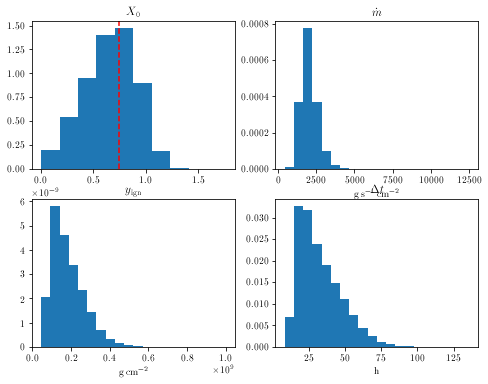

In [36]:
# Ugly but informative plot

fig3, axs3 = plt.subplots(2, 2)
with quantity_support():
    axs3[0,0].hist(x_0, density=True)
    axs3[0,0].set_title('$X_0$')
    axs3[0, 0].axvline(0.75,color='r',linestyle='--')

    axs3[0, 1].hist(m2['mdot'].distribution[g], bins=20, density=True)
    axs3[0, 1].set_title('$\dot{m}$')
    
    axs3[1, 0].hist(y2['yign'].distribution[g], bins=20, density=True)
    axs3[1, 0].set_title('$y_\mathrm{ign}$')
    
    axs3[1, 1].hist(dt1.distribution[g].to('hr'), bins=20, density=True)
    axs3[1, 1].set_title('$\Delta t$')

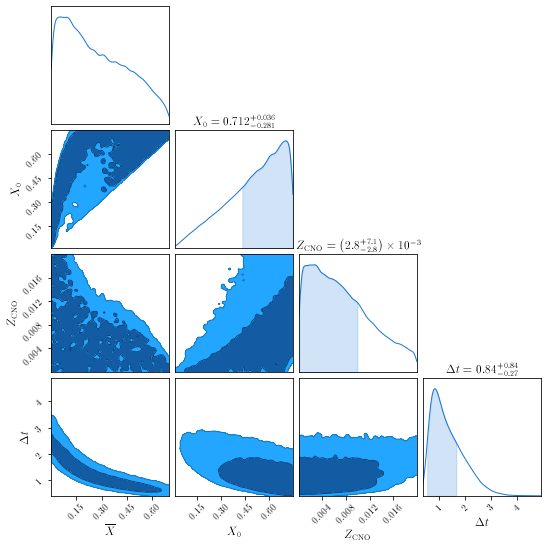

In [37]:
# using instead chainconsumer to plot; see 
# https://samreay.github.io/ChainConsumer/examples/customisations/plot_one_chain.html

data = np.vstack((Xbar.distribution[g].value, 
                  x_0[g], 
                  Z_CNO[g], 
                  dt1.distribution[g].to('d').value)).T
labels = ["$\overline{X}$", "$X_0$", "$Z_\mathrm{CNO}$", "$\Delta t$"]
# labels = ['X', '$X_0$', '$Z_\mathrm{CNO}$', '$Delta t$']

# not sure if this is necessary
matplotlib.rcParams['axes.unicode_minus'] = False

# If you pass in parameter labels and only one chain, you can also get parameter bounds
fig = ChainConsumer().add_chain(data, 
                                parameters=labels).plotter.plot(figsize=(8,8)
# uncomment the following line to save the plot
                                # ,filename='igrJ17591-2342.pdf'
                                )

In [38]:
import pickle

with open("analysis.p","wb") as f:
    pickle.dump(((src, t0, instr), (F_pk, F_pk_err), (F_pers, F_pers_err), (E_b, E_b_err), 
        nsamp, dist2), f)
#     pickle.dump(((src, t0, instr), (F_pk, F_pk_err), (F_pers, F_pers_err), (E_b, E_b_err), 
#         nsamp, dist_theo, dist2, m2, y2, Xbar, x_0, Z_CNO, dt1, g), f)
type(dist_theo['dist'])



PicklingError: Can't pickle <class 'astropy.uncertainty.core.QuantityDistribution'>: attribute lookup QuantityDistribution on astropy.uncertainty.core failed

## 3.5 Zero bursts  – constraining  the distance

Here we compare the results from a study of the accretion-powered millisecond pulsar IGR J00291+5934 [(Galloway et al. 2006)](http://arxiv.org/abs/astro-ph/0604345) with the subsequent detection of a burst from the source [(Kuin et al. 2015)](http://www.astronomerstelegram.org/?read=7849), with distance derivation (via the `dist` method).

In [39]:
src = 'IGR J00291+5934'
F_pk, F_pk_err = 18, 4 # 1e-8 erg/cm^2/s; 

gal06b = (3.9, 5.2) # llim, ulim (@ 3-sigma), for X=0.7
          
# F_pk *= 1e-8*flux_unit
# F_pk_err *= 1e-8*flux_unit

# Generate the distance distributions based on the peak flux, and the
# empirical Eddington luminosity; two options here, the first with no
# constraints on the inclination, the second imposing the inferred
# inclination range of torres08, of 22-32 degrees

dist_all = cd.dist((F_pk*1e-8, F_pk_err*1e-8)*flux_unit, empirical=True, fulldist=True)

dist = cd.dist((F_pk*1e-8, F_pk_err*1e-8)*flux_unit, empirical=True, fulldist=True, imin=22, imax=32)#, plot=True)

# Display the best estimate of the plausible range

dper = np.percentile(dist['dist'].distribution,(50,16,84))
print ('''Distance range including inclination constraints is {:.2f}_{:.2f}^{:.2f} kpc
  incorporates model-predicted anisotropy averaging xi_b = {:.3f}'''.format(
    dper[0],(dper[1]-dper[0]),dper[2]-dper[0],np.mean(dist['xi_b'].distribution)))

# Show the fraction of samples beyond 5 kpc (why?)
print (len(np.where(dist['dist'].distribution > 5.*u.kpc)[0])/len(dist['dist'].distribution))

Distance range including inclination constraints is 4.98 kpc_-0.49 kpc^0.70 kpc kpc
  incorporates model-predicted anisotropy averaging xi_b = 0.705
0.487


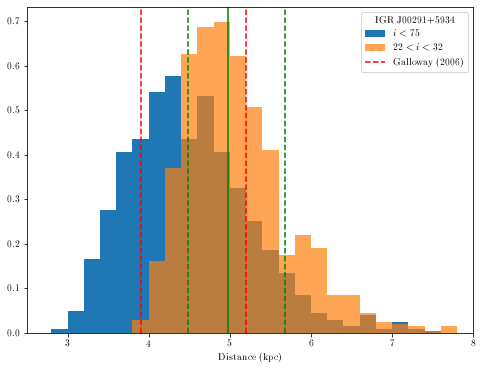

In [40]:
# Plot to compare the 2 distributions

fig1 = plt.figure()
fig1.set_size_inches(8,6)
with quantity_support():
    plt.hist(dist_all['dist'].distribution,bins=np.arange(40)/5.,density=True, 
         label='$i<{:.0f}$'.format(cd.IMAX_NDIP))

    plt.hist(dist['dist'].distribution,bins=np.arange(40)/5.,alpha=0.7,density=True,
        label='${:.0f}<i<{:.0f}$'.format(22,32))
plt.xlim(2.5,8)
plt.xlabel('Distance (kpc)')
# plt.text(7.7, .67, src, horizontalalignment='right')

plt.axvline(dper[0],color='g')
plt.axvline(dper[1],color='g',ls='--')
plt.axvline(dper[2],color='g',ls='--')

plt.axvline(gal06b[0],color='r',ls='--',label='Galloway (2006)')
plt.axvline(gal06b[1],color='r',ls='--')

plt.legend(title=src)

# fig1.savefig("fig1.pdf", bbox_inches='tight')

## 3.6 Observation-model comparisons

Here we provide examples of model-observation comparisons

The simplest case is where we use a code like `settle` (see e.g. [Goodwin et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.490.2228G)) which predicts burst recurrence time and fluence, for a given accretion rate. We describe below how to do the comparison

In [46]:
# for the 1820-30 observations on 1997 May 27

print ('4U 1820-303 epoch {}'.format(obs.table[6][0]))

tdel = cd.decode_LaTeX(obs.table[6][3])
fluen, fluene  = cd.decode_LaTeX(obs.table[6][7])
bc, bce = cd.decode_LaTeX(obs.table[6][5])

d = 7.6*u.kpc
i = 50*u.deg
X_0 = 0.17
Z_CNO = 0.02

# We use the inferred mdot as the input value for the simulations, but in principle
# any value can be used

mdot = 0.144 # in units of mdot_Edd

# this is how we would convert to mdot in g/s/cm^2 as used internally in settle
# mdot *= 1.75*(1.7/(1+X_0))*(1e-8)*(5.01837638e24*u.g/u.s)/(11.2*u.km)**2
# but gal17a throughout uses a fixed value of 8.8×10^4 g cm−2 s−1
mdot *= 8.8e4*u.g/u.cm**2/u.s * 4.*np.pi*(11.2*u.km)**2
# mdot.to('g s-1')# cm-2')

# Settle model predictions give the following
# >>> settle(0.15, 0.02, 0.17, 0.144, 1, 1.4, 11.2)
# rec.array([(2.24151435, 3.13472479, 161.05916546)],
#           dtype=[(‘tdel’, ‘<f8’), (‘E_b’, ‘<f8’), (‘alpha’, ‘<f8’)])

fper_mod = cd.fper(mdot, (d, i, cd.OPZ, 0.0), c_bol=1.45)
# Use lum_to_flux to convert the burst energy to fluence; note the burst flag is set
fluen_mod = cd.lum_to_flux(3.13472479*1e39*u.erg/u.s, d, inclination=i, c_bol=1.,
                           burst=True)*u.s

# Now print out the comparison; this uses the values from a few cells up

print ('\n Parameter                         | Model | Observation  \n-----------------------------------------------------------')
print (' Persistent flux (1e-9 erg/cm^2/s) | {:.3f} | {:.3f}+/-{:.3f}'.format(fper_mod*1e9/(flux_unit), fper*bc, e_fper*bc))
print (' Burst recurrence time (hr)        | {:.3f} | {:.3f}+/-{:.3f}'.format(2.24151435, tdel[0], tdel[1]))
print (' Burst fluence (1e-6 erg/cm^2)     | {:.3f} | {:.3f}+/-{:.3f}'.format((fluen_mod*1e6/(u.erg/u.cm**2)).decompose(), fluen, fluene))

4U 1820-303 epoch 1997 May 4

 Parameter                         | Model | Observation  
-----------------------------------------------------------
 Persistent flux (1e-9 erg/cm^2/s) | 3.258 | 1.692+/-0.009
 Burst recurrence time (hr)        | 2.242 | 2.681+/-0.007
 Burst fluence (1e-6 erg/cm^2)     | 0.505 | 0.381+/-0.003


The full comparison is where we also incorporate the comparison of the lightcurve. That's described here (for a different source)

We use one of the "reference" bursts described by [Galloway et al. (2017)](http://adsabs.harvard.edu/abs/2017PASA...34...19G), provided the data is available in the `data` subdirectory of the concord repo.


ObservedBurst parameters:
  tdel = 3.5300 h
  Fluence = 1.237e-06 +/- 9.400e-09 erg / cm2
  F_per = 1.8700e-09 erg / (cm2 s) +/- 2.0000e-11 erg / (cm2 s)
  Bolometric correction = 1.751
Lightcurve properties
  filename = gs1826-24_3.530h.dat
  time range = (-2.250,211.433 s)
  flux range = (2.300e-10,2.757e-08 erg / (cm2 s))


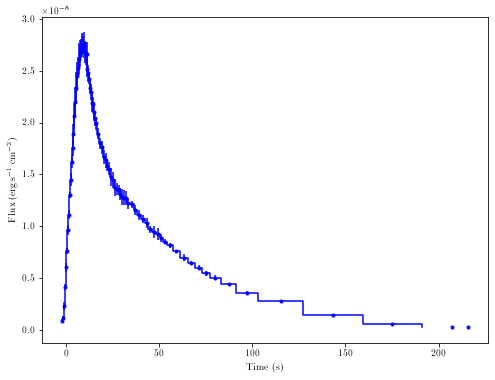

In [47]:
# First read in some test data and generate an ObservedBurst object

obs = cd.ObservedBurst.ref('GS 1826-24', 3.5)

obs.plot()

obs.info()

<class 'concord.burstclass.KeplerBurst'> 4.0503909066119305e+21 kg / yr

KeplerBurst parameters:
  tdel = 2.637 h
  g = 1.8580e+14 cm / s2
  R_Newt = 9.986 km
  R_NS = 11.200 km
  1+z = 1.258
Lightcurve properties
  filename = mean3.data
  time range = (-20.222,160.009 s)
  luminosity range = (3.689e+35,1.969e+38 erg / s)


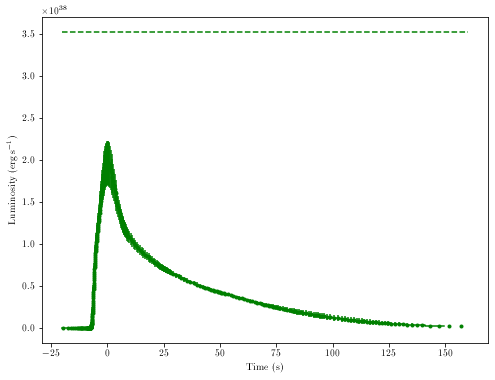

In [48]:
# Now choose some random model for comparison; from Zach, 27/4/17
# after a few more bursts each:
#
# gs1   4.06 +/- 0.17
# gs2   5.30 +/- 0.17
# gs3   3.32 +/- 0.07
#
# and I've attached the newer mean lightcurves in case you also want them.
#
# Redshift is still 1.259
# 
# Mass and radius used in Kepler is 1.4 Msun and 10km, which corresponds to 11.2km radius in GR (with same mass). 
# Gravity is 1.858e+14 (cgs)
# 
# > On 27 Apr 2017, at 3:53 PM, Zac Johnston Johnston <zac.johnston@monash.edu> wrote:
# >
# > The follow ups are still running but they've got ~10 bursts each now so probably enough to have a look.
# >
# > #mod     acc rate        Z             H             Lacc/Ledd  ||  recurrence time (hr)
# > gs1   2.037000e-09    0.0050    0.7000    0.1164        ||  4.1 +/- 0.1
# > gs2   1.654625e-09    0.0050    0.7000    0.0945        ||  5.4 +/- 0.2
# > gs3   2.409750e-09    0.0050    0.7000    0.1377        ||  3.3 +/- 0.1

M_NS, R_NS = 1.4*const.M_sun, 11.2*u.km

opz = cd.redshift(M_NS, R_NS)

c_loZ = cd.KeplerBurst(filename='mean3.data',path='example_data',
                  lAcc=0.1164,Z=0.005,H=0.7,
                  tdel=3.32/opz,tdel_err=0.07/opz,
                  g = 1.858e+14*u.cm/u.s**2, R_NS=11.2*u.km) # R_Newt=10*u.km) # would be more precise

print (type(c_loZ), c_loZ.mdot)

c_loZ.plot()

c_loZ.info()

6785.10234313521


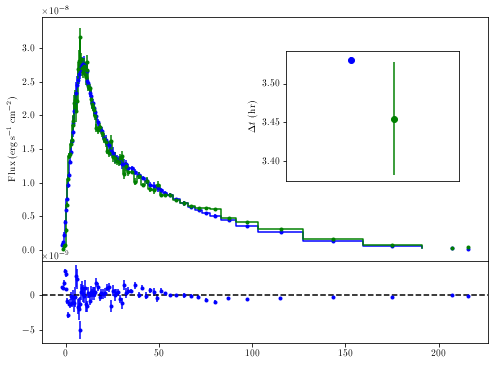

In [49]:
# plt.title('GS 1826$-$24')

l = obs.compare(c_loZ,param = [7.5*u.kpc,60.*u.degree,1.31,-6.5*u.s], plot=True)

plt.rcParams["figure.figsize"] = (8,6)

print (l)
# plt.savefig("lc_comp.pdf", bbox_inches='tight')

### Modification history

31/1/2022 - trimmed some of the older (now redundant) analyses

27/1/2022 - The Kepler run information is now read in from a machine-readable table that will be distributed with the paper (and concord repository)

### Future work

To do before submitting the paper:
* Expand the references to proper links, and in-line citations
* Clean up the code and comments, and remove extraneous stuff
* Add in a routine to do the distance estimate as for XMMU J181227.8-181234, where you compare the mdot implied by the burst recurrence time to the persistent flux